In [28]:
import glob
import numpy as np

output_folder = 'output/z/'
npzfiles = glob.glob(output_folder + "/*.npz") # saved npz files
thresholds = {np.float(f.split('/')[-1][9:-4]) : f for f in npzfiles}
#thresholds = np.asarray([filename.split('/')[-1][9:-4] for filename in npzfiles]).astype(np.float) # l1 loss weight
z = {npzfile:np.load(npzfile) for npzfile in npzfiles} # list of saved Weights
keys = z.values()[0].files # name of layers in Weights

In [40]:
# compute number of non-zeros in each layer across thresholds
nnz = []
sort_thresh = np.sort(thresholds.keys())
for key in keys:
    nnz.append([np.sum(z[thresholds[s]][key] != 0) for s in sort_thresh])
len(nnz)

22

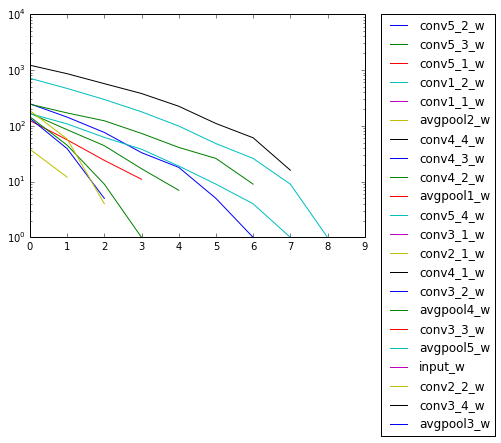

In [46]:
%matplotlib inline

import matplotlib.pyplot as plt

for line, key in zip(nnz, keys):
    plt.semilogy(line[-10:], label=key)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [49]:
[(key,line[-5]) for key, line in zip(keys , nnz)]

[('conv5_2_w', 5),
 ('conv5_3_w', 0),
 ('conv5_1_w', 0),
 ('conv1_2_w', 0),
 ('conv1_1_w', 0),
 ('avgpool2_w', 0),
 ('conv4_4_w', 110),
 ('conv4_3_w', 0),
 ('conv4_2_w', 0),
 ('avgpool1_w', 0),
 ('conv5_4_w', 48),
 ('conv3_1_w', 0),
 ('conv2_1_w', 0),
 ('conv4_1_w', 0),
 ('conv3_2_w', 0),
 ('avgpool4_w', 26),
 ('conv3_3_w', 0),
 ('avgpool5_w', 9),
 ('input_w', 0),
 ('conv2_2_w', 0),
 ('conv3_4_w', 0),
 ('avgpool3_w', 0)]

In [56]:
np.nonzero(z[thresholds[sort_thresh[-5]]]['conv4_4_w'])

(array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,
         3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  7,
         8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13,
        13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 14, 14, 15, 15, 15]),
 array([ 1,  2, 13, 13, 14, 14, 15, 13, 13, 14, 15, 12, 13, 13, 14, 13, 13,
        14, 13, 13, 14, 12, 13, 13, 14, 12, 13, 13, 14, 12, 13, 13, 13, 14,
        12, 13, 13, 13, 14, 12, 13, 13, 13, 13, 14, 14, 14, 15, 12, 13, 13,
        13, 13, 13, 14, 14, 14, 14, 14, 15, 12, 13, 13, 13, 13, 13, 14, 14,
        14, 14, 14, 15, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 11,
        12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 12, 13,
        13, 14, 14, 14, 15, 13, 13, 14]),
 arr

In [55]:
z[thresholds[sort_thresh[-5]]]['conv5_2_w'].shape

(8, 8, 512)